## Setup

### Imports

In [3]:
import time
import joblib
import numpy as np
import imgaug as ia
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import svm
from memory_profiler import memory_usage
import pandas as pd

In [ ]:
from utility import get_memory_usage_and_runtime, auc_roc_curves
from data_preprocessing import get_dataset

In [ ]:
def get_svm_dataset(use_external=False, aug_data=False):
    '''
    Load dataset for SVM
    '''
    x_train, x_val, x_test, y_train, y_val, y_test = get_dataset(use_external=use_external, aug_data=aug_data)

    def flatten(x):
        return x.reshape(x.shape[0], -1)

    return flatten(x_train), flatten(x_val), flatten(x_test), y_train, y_val, y_test

### Helper functions

In [5]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def svm_decision_boundry_PCA(x_train, y_train, title = ""):
  # appply pca for visualization of nonliner kernel (rbf)
  pca = PCA(n_components=2)
  x_train_PCA = pca.fit_transform(x_train)

  svm_model_pca = svm.SVC(kernel='rbf')
  svm_model_pca.fit(x_train_PCA, y_train)

  # construct mesh grid of points
  x_min, x_max = x_train_PCA[:, 0].min(), x_train_PCA[:, 0].max()
  y_min, y_max = x_train_PCA[:, 1].min(), x_train_PCA[:, 1].max()
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

  # predict on mesh grid of points using pca dimensionally adjusted SVM
  Z = svm_model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  # plot
  plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
  plt.scatter(x_train_PCA[:, 0], x_train_PCA[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
  plt.title('SVM Decision Boundary (Nonlinear Kernel, PCA Space)'+ title)
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.show()

def get_metrics_svm(x_test, y_test, scaler, pca, svm_model):
  runtime, peak_mem, (y_pred, acc) = get_memory_usage_and_runtime(eval, (x_test, y_test, scaler, pca, svm_model,))
  precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

  return acc, runtime/y_test.shape[0], peak_mem/y_test.shape[0], np.mean(f1_score), y_pred

In [6]:
def train_preprocess(x, pca_var):
    '''
    Fit MinMaxScaler and PCA on SVM train data
    '''
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    pca = PCA(n_components=pca_var)
    x = pca.fit_transform(x)

    return scaler, pca

def train_svm(x, y, svm_c):
    '''
    Train the SVM model
    '''
    svm_model = svm.SVC(kernel='rbf', probability=True, C=svm_c)
    svm_model.fit(x, y)

    return svm_model

def train(x, y, pca_var=0.7, svm_c=1.0, preprocess=True, scaler=None, pca=None):
    '''
    Train the entire SVM pipeline (MinMaxScaler + PCA + SVM)
    '''
    if preprocess:
        scaler, pca = train_preprocess(x, pca_var)

    assert scaler and pca

    x = scaler.transform(x)
    x = pca.transform(x)

    svm_model = train_svm(x, y, svm_c)

    return scaler, pca, svm_model

def preprocess_data(x, scaler, pca):
    '''
    Helper function to scale and apply PCA to data
    '''
    x = scaler.transform(x)
    x = pca.transform(x)
    return x

def eval(x, y, scaler, pca, svm_model):
    '''
    Helper function to evaluate the SVM model
    '''
    x = scaler.transform(x)
    x = pca.transform(x)

    y_pred = svm_model.predict(x)

    return y_pred, accuracy_score(y_pred, y)

### Load Data

In [8]:
# load datasets
x_train_o, x_val_o, x_test_o, y_train_o, y_val_o, y_test_o = get_svm_dataset(use_external=False, aug_data=False)
x_train_a, x_val_a, x_test_a, y_train_a, y_val_a, y_test_a = get_svm_dataset(use_external=False, aug_data=True)
x_train_d, x_val_d, x_test_d, y_train_d, y_val_d, y_test_d = get_svm_dataset(use_external=True, aug_data=True)

## Hyperparameter Tuning on Original Dataset

#### PCA variance

Make PCA preserve different amounts of variance and see how it affects accuracy, as well as time and memory usage.

In [ ]:
pca_vars = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

accs = []
runtimes = []
peak_mems = []

for pca_var in pca_vars:
    scaler, pca, svm_model = train(x_train_o, y_train_o, preprocess=True, pca_var=pca_var)

    y_pred, val_acc = eval(x_val_o, y_val_o, scaler, pca, svm_model)
    accs.append(val_acc)

    x_val_preprocessed = preprocess_data(x_val_o, scaler, pca)
    runtime, peak_mem, _ = get_memory_usage_and_runtime(svm_model.predict, (x_val_preprocessed,))
    runtimes.append(runtime)
    peak_mems.append(peak_mem)

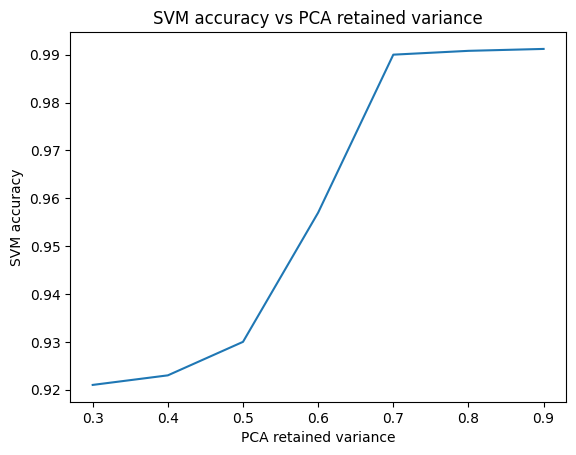

In [ ]:
# plot the affect on accuracy

plt.figure()
plt.plot(pca_vars, accs)
plt.xlabel('PCA retained variance')
plt.ylabel('SVM Validation Accuracy')
plt.title('SVM Validation Accuracy vs PCA retained variance - Original Dataset')

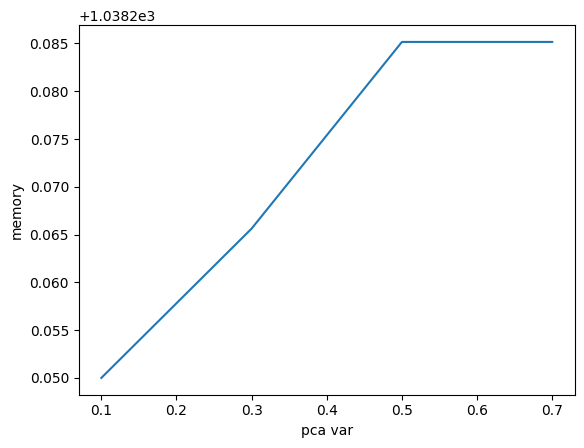

In [ ]:
# plot the affect on peak memory

plt.figure()
plt.plot(pca_vars, peak_mems)
plt.xlabel('PCA retained variance')
plt.ylabel('Overall Memory Usage (MB) on the Validation Set')
plt.title('SVM Memory Usage vs PCA retained variance')
plt.show()

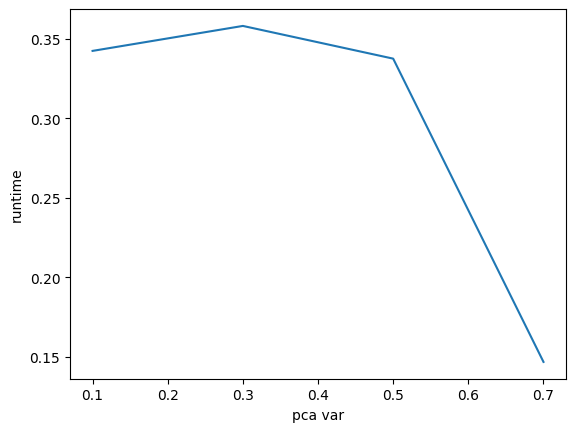

In [ ]:
# plot the affect on runtime

plt.plot(pca_vars, runtimes)
plt.xlabel('PCA retained variance')
plt.ylabel('Overall Runtime(s) on the Validation Set')
plt.title('SVM Runtime vs PCA retained variance')
plt.show()

#### SVM regularization

Tune SVM regularization parameter, and visualize the affect on accuracy.

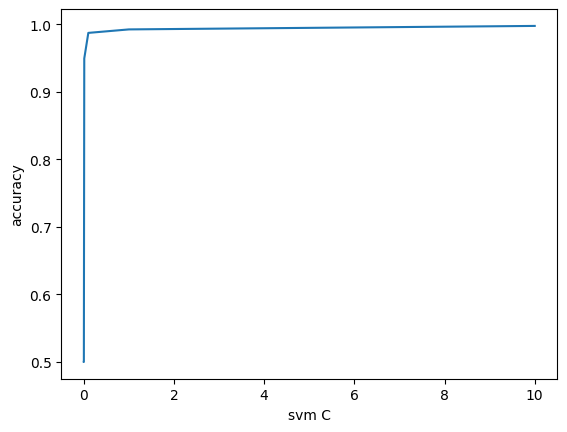

In [ ]:
svm_c_vals = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
accs = []

for svm_c in svm_c_vals:
    scaler, pca, svm_model = train(x_train_o, y_train_o, pca_var=0.7, svm_c=svm_c, preprocess=True)
    y_pred, val_acc = eval(x_val_o, y_val_o, scaler, pca, svm_model)

    accs.append(val_acc)

plt.plot(svm_c_vals, accs)
plt.xlabel('SVM regularization parameter C')
plt.ylabel('Validation Accuracy')
lt.title('SVM Validation Accuracy vs Regularization Parameter C')
plt.show()

## Train and Validation Evaluation

Evaluate on the validation set, the final SVM model after tuning hyperparameters on different subsets of our training data

#### Original Dataset

In [ ]:
# train
scaler_o, pca_o, svm_model_o = train(x_train_o, y_train_o, pca_var=0.7, svm_c=1.0)
x_val_preprocessed_0 = preprocess_data(x_val_o, scaler_o, pca_o)

# evaluate on validation set
runtime_o, peak_mem_o, _ = get_memory_usage_and_runtime(svm_model_o.predict, (x_val_preprocessed,))
y_pred_o, acc_o = eval(x_val_o, y_val_o, scaler, pca, svm_model)

print("Validation Accuracy on Original Dataset: ", acc_o)

In [ ]:
# Save Original
joblib.dump(svm_model, 'svm_original.pkl')
joblib.dump(scaler, 'scaler_original.pkl')
joblib.dump(pca, 'pca_original.pkl')

#### Augmented Dataset

In [ ]:
# Limit the training size
n = 10000
x_train_a, y_train_a = x_train_a[:n], y_train_a[:n]

# train
scaler_a, pca_a, svm_model_a = train(x_train_a, y_train_a, pca_var=0.7, svm_c=1.0)
x_val_preprocessed_a = preprocess_data(x_val_a, scaler_a, pca_a)

# evaluate on validation set
runtime_a, peak_mem_a, _ = get_memory_usage_and_runtime(svm_model_a.predict, (x_val_preprocessed_a,))
y_pred_a, acc_a = eval(x_val_a, y_val_a, scaler_a, pca_a, svm_model_a)

print("Validation Accuracy on Augmented Dataset: ", acc_a)

In [ ]:
# Save Augmented
joblib.dump(svm_model, 'svm_augmented.pkl')
joblib.dump(scaler, 'scaler_augmented.pkl')
joblib.dump(pca, 'pca_augmented.pkl')

#### External Dataset

In [ ]:
# Limit the training size
n = 10000
x_train_d, y_train_d = x_train_d[:n], y_train_d[:n]

# train
scaler_d, pca_d, svm_model_d = train(x_train_d, y_train_d, pca_var=0.7, svm_c=1.0)
x_val_preprocessed_d = preprocess_data(x_val_d, scaler_d, pca_d)

# evaluate on avlidation set
runtime, peak_mem, _ = get_memory_usage_and_runtime(svm_model_d.predict, (x_val_preprocessed_d,))
y_pred_d, acc_d = eval(x_val_d, y_val_d, scaler_d, pca_d, svm_model_d)

print("Validation Accuracy on External Dataset: ", acc_d)

In [ ]:
# Save External
joblib.dump(svm_model, 'svm_augmented_and_external.pkl')
joblib.dump(scaler, 'scaler_augmented_and_external.pkl')
joblib.dump(pca, 'pca_augmented_and_external.pkl')

## Test Evaluation

In [10]:
# load models from saved
model_folder = '/content/drive/My Drive/Capstone 2023/Saved Models/svm/' # change to /models/svm folder

# original
svm_model_o = joblib.load(model_folder+'svm_original.pkl')
scaler_o = joblib.load(model_folder+'scaler_original.pkl')
pca_o = joblib.load(model_folder+'pca_original.pkl')
accuracy_o, runtime_o, peak_mem_o, f1_o, y_pred_o = get_metrics_svm(x_test_o, y_test_o, scaler_o, pca_o, svm_model_o)

# augmented
svm_model_a = joblib.load(model_folder+'svm_augmented.pkl')
scaler_a = joblib.load(model_folder+'scaler_augmented.pkl')
pca_a = joblib.load(model_folder+'pca_augmented.pkl')
accuracy_a, runtime_a, peak_mem_a, f1_a, y_pred_a = get_metrics_svm(x_test_a, y_test_a, scaler_a, pca_a, svm_model_a)

# external
svm_model_d = joblib.load(model_folder+'svm_augmented_and_external.pkl')
scaler_d = joblib.load(model_folder+'scaler_augmented_and_external.pkl')
pca_d = joblib.load(model_folder+'pca_augmented_and_external.pkl')
accuracy_d, runtime_d, peak_mem_d, f1_d, y_pred_d = get_metrics_svm(x_test_d, y_test_d, scaler_d, pca_d, svm_model_d)


results = {
    "Data": ["Original", "Augmented", "Augmented + External"],
    "Accuracy": [accuracy_o, accuracy_a, accuracy_d],
    "Runtime (1 img)": [runtime_o, runtime_a, runtime_d],
    "Peak Memory (1 img)": [peak_mem_o, peak_mem_a, peak_mem_d],
    "Average F1 Score": [f1_o, f1_a, f1_d]
}

results_pd = pd.DataFrame(results)
results_pd

,Data,Accuracy,Runtime (1 img),Peak Memory (1 img),Average F1 Score
0,Original,0.996774,0.000348,1.486303,0.996774
1,Augmented,0.986290,0.000854,1.486303,0.986288
2,Augmented + External,0.987903,0.001096,1.486303,0.987901


### Confusion matricies

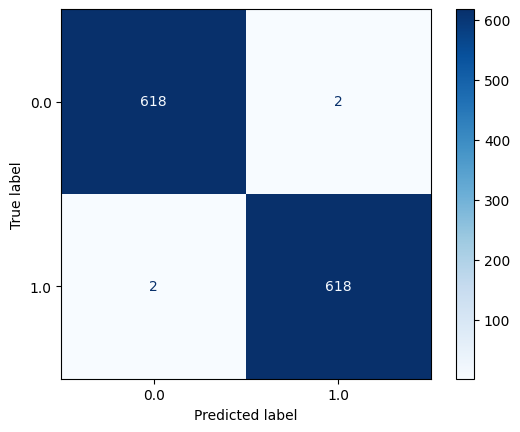

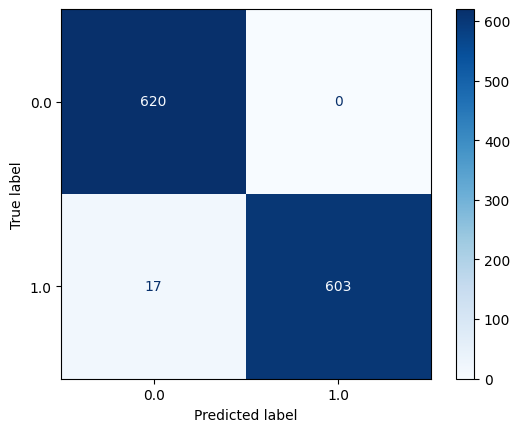

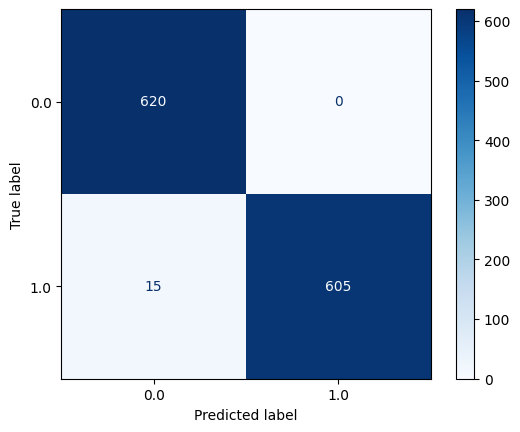

In [ ]:
# Original dataset
plot_confusion_matrix(y_test_o, y_pred_o)

# Augmented dataset
plot_confusion_matrix(y_test_a, y_pred_a)

# Augmented + External dataset
plot_confusion_matrix(y_test_d, y_pred_d)

### AUC_ROC

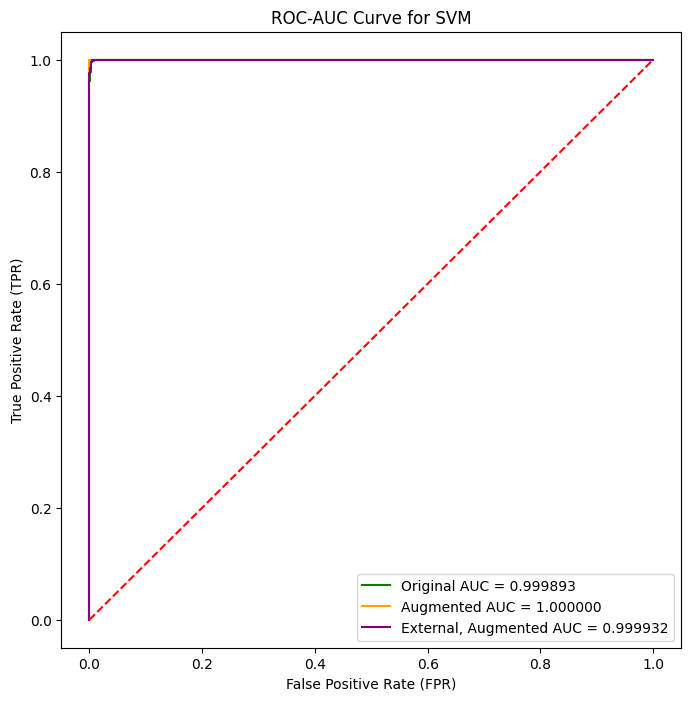

In [14]:
# Get probabilities
y_probs_o = svm_model_o.predict_proba(preprocess_data(x_test_o, scaler_o, pca_o))[:, 1]
y_probs_a = svm_model_a.predict_proba(preprocess_data(x_test_a, scaler_a, pca_a))[:, 1]
y_probs_d = svm_model_d.predict_proba(preprocess_data(x_test_d, scaler_d, pca_d))[:, 1]


auc_roc_curve_data = [
    (y_test_o, y_probs_o, "green", "Original"),
    (y_test_a, y_probs_a, "orange", "Augmented"),
    (y_test_d, y_probs_d, "purple", "External, Augmented"),
    ]

auc_roc_curves(auc_roc_curve_data, "SVM")

### Decision Boundaries

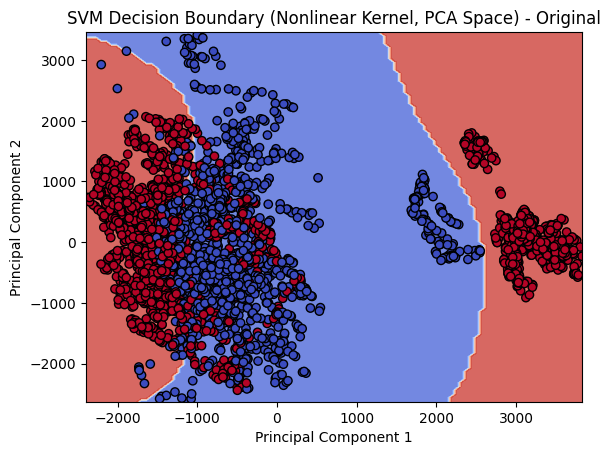

In [ ]:
# Original Dataset
svm_decision_boundry_PCA(x_train_o, y_train_o, " - Original")

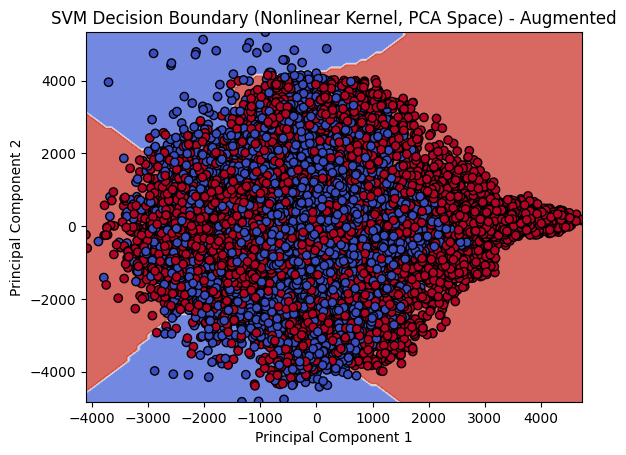

In [ ]:
# Augmented Dataset
svm_decision_boundry_PCA(x_train_a, y_train_a, " - Augmented")

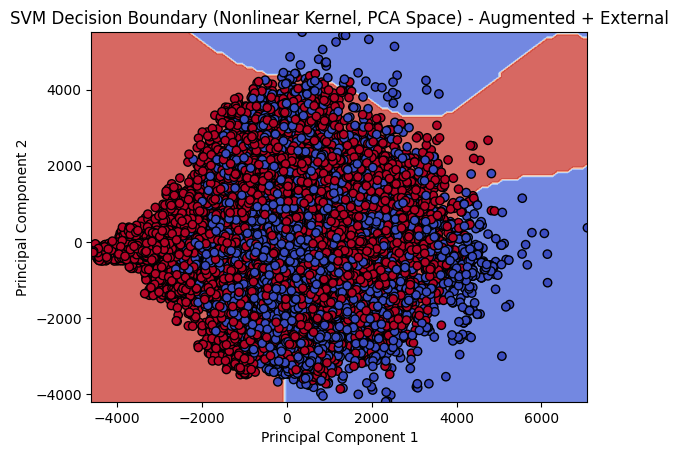

In [ ]:
# Augmented + External Dataset
svm_decision_boundry_PCA(x_train_d, y_train_d, " - Augmented + External")